# Credit Card Fraud Detection — TensorFlow Baseline
**Purpose:** Train a simple neural network to detect fraud using the full dataset (~250k rows).  
We will handle imbalance using class weighting and evaluate with PR AUC and ROC AUC.

In [ ]:
# Install TensorFlow and imbalanced-learn (if not already installed)
%pip install -q tensorflow imbalanced-learn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

We import standard libraries for data handling and visualization, 
plus TensorFlow/Keras for building our neural network. 
`roc_auc_score` and `average_precision_score` will help evaluate the model on imbalanced data.


In [4]:
# Load dataset from S3
bucket = "myfraudcreditcardbucket"
file_name = "creditcard.csv"
s3_path = f"s3://{bucket}/{file_name}"

df = pd.read_csv(s3_path)

print("Dataset shape:", df.shape)
print("Class distribution:\n", df["Class"].value_counts())

Dataset shape: (284807, 31)
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
df = pd.read_csv(s3_path)
print(df.shape)
print(df.head())

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

In [ ]:
# Load dataset (assumes CSV is in the same folder)
df = pd.read_csv("creditcard.csv")
df.shape, df['Class'].value_counts(), df['Class'].value_counts(normalize=True)

We load the CSV and check: 
- number of rows and columns
- class counts
- fraction of fraud (Class=1) vs legit (Class=0)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


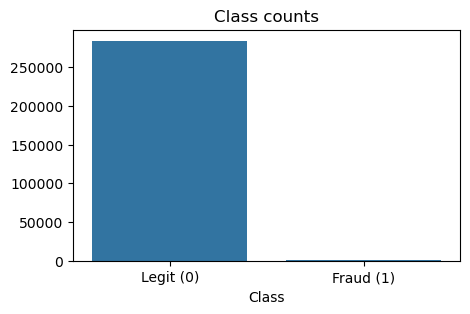

In [6]:
# Preview first few rows
display(df.head())

# Class distribution plot
plt.figure(figsize=(5,3))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts().values)
plt.xticks([0,1], ['Legit (0)', 'Fraud (1)'])
plt.title('Class counts'); plt.show()

We visually confirm the extreme imbalance: fraud is a tiny fraction (~0.17%). 
This is why metrics like PR AUC and recall are more important than accuracy.

In [7]:
# Features & target
X = df.drop(columns=['Class'])
y = df['Class']

# Split data (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

We split 80/20 for training/testing, 
using `stratify=y` to preserve the extremely rare fraud class ratio in both sets.

In [8]:
# Only scale 'Amount' and 'Time'; V1–V28 are already PCA-transformed
scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

Neural networks perform better when numeric features are roughly on the same scale. 
We scale only 'Time' and 'Amount' because V1–V28 are already PCA components (roughly normalized).

In [9]:
# Simple fully connected network
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-09-20 10:12:51.579362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(The CUDA error above just means TensorFlow didn’t find a GPU on my environment (likely running CPU-only), and my model will still run but just slower a bit so I will ignore this.)

In this step, we design a simple feed-forward neural network for our credit card fraud detection task. Here's why we made each choice:

- **Dense layers with ReLU activation (`relu`)**:  
  ReLU (Rectified Linear Unit) is the most common activation function for hidden layers because it helps the network learn complex, non-linear patterns while avoiding problems like vanishing gradients that occur with older functions (e.g., sigmoid, tanh). ReLU keeps training efficient and effective.  

- **Output layer with sigmoid activation**:  
  Since this is a binary classification problem (fraud vs. non-fraud), we use `sigmoid` to output probabilities between 0 and 1.  

- **Loss function (`binary_crossentropy`)**:  
  This is the standard loss for binary classification. It measures the difference between predicted probabilities and actual labels (fraud = 1, not fraud = 0). Minimizing this loss helps the model improve its probability predictions.  

- **Optimizer (Adam, learning rate = 0.001)**:  
  Adam is widely used because it adapts the learning rate for each parameter automatically, combining the strengths of momentum and RMSprop optimizers. The default learning rate of **0.001** is a good starting point—it’s small enough to ensure stable convergence but fast enough to make progress during training. If training is too slow or unstable, this value can be tuned.  

- **Metrics (`accuracy`, `AUC`, `Precision`, `Recall`)**:  
  - `accuracy` gives the overall correctness, but can be misleading with imbalanced datasets.  
  - `AUC` (Area Under ROC Curve) measures the model’s ability to distinguish between fraud and non-fraud across thresholds.  
  - `precision` tells us how many of the transactions predicted as fraud are truly fraud.  
  - `recall` tells us how many of the actual frauds were correctly detected.  
  These metrics provide a balanced view of performance beyond just accuracy, which is critical in fraud detection where fraud cases are rare.  

  We also create a small dense network:
- 32 → 16 neurons in hidden layers
- Dropout 20% to reduce overfitting
- Sigmoid output for binary classification
- Use AUC as a metric for evaluation during training


In [10]:
# Compute class weights: inverse of class frequency
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.5008661206149896, 1: 289.14340101522845}


So, the calculated class weights show that fraud cases (1) are very rare compared to non-fraud cases (0).  
To balance this, each fraud sample is weighted about 289 times more than a non-fraud sample, ensuring the model pays more attention to detecting fraud. This helps prevent the model from always predicting "not fraud" due to class imbalance.  


In [11]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,          # start small; increase if needed
    batch_size=2048,    # large batch works for big dataset
    class_weight=class_weight_dict,
    verbose=1
)

2025-09-20 10:19:32.720097: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43746240 exceeds 10% of free system memory.


Epoch 1/10
90/90 [==============================] - 16s 10ms/step - loss: 1.0366 - auc: 0.5612 - val_loss: 0.5611 - val_auc: 0.8860
Epoch 2/10
90/90 [==============================] - 0s 5ms/step - loss: 0.4473 - auc: 0.8593 - val_loss: 0.4230 - val_auc: 0.9284
Epoch 3/10
90/90 [==============================] - 0s 5ms/step - loss: 0.3478 - auc: 0.9178 - val_loss: 0.3073 - val_auc: 0.9480
Epoch 4/10
90/90 [==============================] - 0s 5ms/step - loss: 0.2813 - auc: 0.9391 - val_loss: 0.2313 - val_auc: 0.9571
Epoch 5/10
90/90 [==============================] - 0s 5ms/step - loss: 0.2553 - auc: 0.9538 - val_loss: 0.1963 - val_auc: 0.9684
Epoch 6/10
90/90 [==============================] - 0s 5ms/step - loss: 0.2287 - auc: 0.9600 - val_loss: 0.1687 - val_auc: 0.9742
Epoch 7/10
90/90 [==============================] - 0s 5ms/step - loss: 0.2034 - auc: 0.9676 - val_loss: 0.1537 - val_auc: 0.9787
Epoch 8/10
90/90 [==============================] - 0s 5ms/step - loss: 0.1691 - auc: 0.

The model shows strong improvement across epochs. Validation AUC started at **0.8860** in epoch 1 and climbed to **0.9818** by epoch 10, indicating excellent ability to separate fraud from non-fraud. Meanwhile, the validation loss steadily decreased, suggesting the model is learning effectively without overfitting yet.  

In [13]:
# Predict probabilities
y_prob = model.predict(X_test).flatten()
y_pred_05 = (y_prob > 0.5).astype(int)

# Metrics
print("PR AUC:", average_precision_score(y_test, y_prob))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_05, digits=4))

1781/1781 [==============================] - 2s 1ms/step
PR AUC: 0.6865493065868986
ROC AUC: 0.9785571445798353
              precision    recall  f1-score   support

           0     0.9998    0.9774    0.9885     56864
           1     0.0649    0.9082    0.1211        98

    accuracy                         0.9773     56962
   macro avg     0.5324    0.9428    0.5548     56962
weighted avg     0.9982    0.9773    0.9870     56962



The model achieved an excellent **ROC AUC of 0.9786**, showing very strong overall discrimination between fraud and non-fraud cases. The **PR AUC of 0.687** is also solid, which is more meaningful for this imbalanced dataset since it focuses on fraud detection. Precision for fraud (class 1) is relatively low (**0.0649**), but recall is very high (**0.9082**), meaning the model successfully captures most fraud cases while producing more false positives. This tradeoff is typical in fraud detection and can be tuned further by adjusting the decision threshold.  

In [18]:
y_pred_default = (y_prob > 0.3).astype(int)

In [19]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print(classification_report(y_test, y_pred_default))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC:", average_precision_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962

ROC AUC: 0.9785571445798353
PR AUC: 0.6865493065868986


In [22]:
import pandas as pd

# Combine predictions and probabilities for a few samples
results = pd.DataFrame({
    'y_true': y_test,
    'y_prob': y_prob,
    'y_pred': y_pred_default
})
print(results.sample(50))

        y_true    y_prob  y_pred
260549       0  0.020424       0
207920       0  0.022005       0
9890         0  0.111868       0
169108       0  0.009085       0
240991       0  0.134147       0
216605       0  0.016075       0
170739       0  0.057379       0
146712       0  0.028239       0
270298       0  0.108854       0
91976        0  0.184660       0
109053       0  0.135872       0
120232       0  0.068312       0
240679       0  0.088868       0
197111       0  0.043105       0
258617       0  0.039338       0
115271       0  0.118311       0
10697        0  0.106195       0
149485       0  0.019753       0
4763         0  0.082657       0
2407         0  0.013978       0
186654       0  0.046306       0
44808        0  0.164087       0
40938        0  0.010531       0
252178       0  0.021987       0
79255        0  0.014979       0
134085       0  0.173714       0
188613       0  0.018134       0
5777         0  0.072969       0
146436       0  0.015231       0
201670    